Check GPU and instantiate model - will download weights.

In [1]:
import numpy as np
from cellpose import models, core, io, plot
from pathlib import Path
from tqdm import trange
import matplotlib.pyplot as plt
from natsort import natsorted

io.logger_setup() # run this to get printing of progress

#Check if colab notebook instance has GPU access
if core.use_gpu()==False:
  raise ImportError("No GPU access, change your runtime")

model = models.CellposeModel(gpu=True)

2025-11-03 14:39:25,291 [INFO] WRITING LOG OUTPUT TO /Users/gmgao/.cellpose/run.log
2025-11-03 14:39:25,292 [INFO] 
cellpose version: 	4.0.7 
platform:       	darwin 
python version: 	3.10.19 
torch version:  	2.9.0
2025-11-03 14:39:25,317 [INFO] ** TORCH MPS version installed and working. **
2025-11-03 14:39:25,318 [INFO] ** TORCH MPS version installed and working. **
2025-11-03 14:39:25,318 [INFO] >>>> using GPU (MPS)
2025-11-03 14:39:25,946 [INFO] >>>> loading model /Users/gmgao/.cellpose/models/cpsam


Input directory with your images:

In [2]:
# *** change to your google drive folder path ***
dir = "/Volumes/guttman/Guoming_Gao-Resnick/Imaging_ProcessedData/C9_paper/20250912-C9in1b_odd_even/composite"
dir = Path(dir)
if not dir.exists():
    raise FileNotFoundError("directory does not exist")

# *** change to your image extension ***
image_ext = ".tif"

# list all files
files = natsorted(
    [
        f
        for f in dir.glob("*" + image_ext)
        if "_masks" not in f.name and "_flows" not in f.name
    ]
)

if len(files) == 0:
    raise FileNotFoundError(
        "no image files found, did you specify the correct folder and extension?"
    )
else:
    print(f"{len(files)} images in folder:")

for f in files:
    print(f.name)

21 images in folder:
5280-DAPI-488_C9In1bOdd-Cy5_C9In1bEven_1_MMStack_Pos0.ome_composite_stack.tif
10689-DAPI-488_C9In1bOdd-Cy5_C9In1bEven_1_MMStack_Pos0.ome_composite_stack.tif
10689-DAPI-488_C9In1bOdd-Cy5_C9In1bEven_2_MMStack_Pos0.ome_composite_stack.tif
10689-DAPI-488_C9In1bOdd-Cy5_C9In1bEven_3_MMStack_Pos0.ome_composite_stack.tif
10689-DAPI-488_C9In1bOdd-Cy5_C9In1bEven_4_MMStack_Pos0.ome_composite_stack.tif
10689-DAPI-488_C9In1bOdd-Cy5_C9In1bEven_5_MMStack_Pos0.ome_composite_stack.tif
10689-DAPI-488_C9In1bOdd-Cy5_C9In1bEven_6_MMStack_Pos0.ome_composite_stack.tif
10689-DAPI-488_C9In1bOdd-Cy5_C9In1bEven_7_MMStack_Pos0.ome_composite_stack.tif
10689-DAPI-488_C9In1bOdd-Cy5_C9In1bEven_8_MMStack_Pos0.ome_composite_stack.tif
10689-DAPI-488_C9In1bOdd-Cy5_C9In1bEven_9_MMStack_Pos0.ome_composite_stack.tif
10689-DAPI-488_C9In1bOdd-Cy5_C9In1bEven_10_MMStack_Pos0.ome_composite_stack.tif
12099-DAPI-488_C9In1bOdd-Cy5_C9In1bEven_1_MMStack_Pos0.ome_composite_stack.tif
12099-DAPI-488_C9In1bOdd-Cy5_C9

## Run Cellpose-SAM on one image in folder

Here are some of the parameters you can change:

* ***flow_threshold*** is  the  maximum  allowed  error  of  the  flows  for  each  mask.   The  default  is 0.4.
    *  **Increase** this threshold if cellpose is not returning as many masks as you’d expect (or turn off completely with 0.0)
    *   **Decrease** this threshold if cellpose is returning too many ill-shaped masks.

* ***cellprob_threshold*** determines proability that a detected object is a cell.   The  default  is 0.0.
    *   **Decrease** this threshold if cellpose is not returning as many masks as you’d expect or if masks are too small
    *   **Increase** this threshold if cellpose is returning too many masks esp from dull/dim areas.

* ***tile_norm_blocksize*** determines the size of blocks used for normalizing the image. The default is 0, which means the entire image is normalized together.
  You may want to change this to 100-200 pixels if you have very inhomogeneous brightness across your image.



(3, 2048, 2048) 51074.0
your image has shape: (3, 2048, 2048). Assuming channel dimension is last with 2048 channels


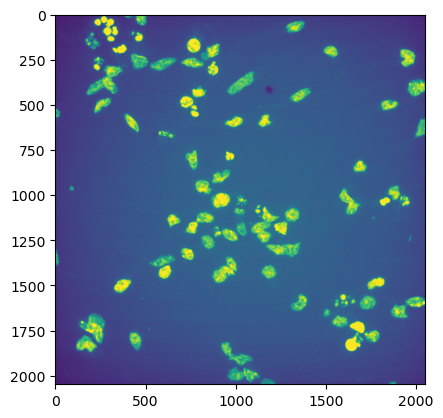

In [32]:
img = io.imread(files[5])

print(img.shape, np.ptp(img))

print(
    f"your image has shape: {img.shape}. Assuming channel dimension is last with {img.shape[-1]} channels"
)

# Check channels
img_test = img[2,:,:]
plt.imshow(img_test, vmax=np.quantile(img_test,0.99))

### Channel Selection: 

- Use the dropdowns below to select the _zero-indexed_ channels of your image to segment. The order does not matter. Remember to rerun the cell after you edit the dropdowns.

- If you have a histological image taken in brightfield, you don't need to adjust the channels.

- If you have a fluroescent image with multiple stains, you should choose one channel with a cytoplasm/membrane stain, one channel with a nuclear stain, and set the third channel to `None`. Choosing multiple channels may produce segmentaiton of all the structures in the image. If you have retrained the model on your data with a thrid stain (described below), you can run segmentation with all channels. 

In [53]:
# Cytoplasm/membrane stain
first_channel = "1"  # @param ['None', 0, 1, 2, 3, 4, 5]
# Nuclear stain
second_channel = "2"  # @param ['None', 0, 1, 2, 3, 4, 5]
# optional stain, leave none
third_channel = "None"  # @param ['None', 0, 1, 2, 3, 4, 5]
selected_channels = []
for i, c in enumerate([first_channel, second_channel, third_channel]):
    if c == "None":
        continue
    if int(c) > img.shape[-1]:
        assert (
            False
        ), "invalid channel index, must have index greater or equal to the number of channels"
    if c != "None":
        selected_channels.append(int(c))


def normalize_img(img_in):
    img_float = img_in.astype(np.float32)
    max_val = np.max(img_float)
    if max_val > 0:
        img_float /= max_val
    return img_float


# Prepare your two-channel image (cyto in channel 0, nucleus in channel 1)
img_selected_channels = np.zeros_like(img)
img_selected_channels[: len(selected_channels), :, :] = normalize_img(
    img[selected_channels, :, :]
)

# --- 1. Segment WHOLE CELLS using both channels ---
masks_cells, flows_cells, styles_cells = model.eval(
    img_selected_channels,  # Contains both cyto (ch 0) and nucleus (ch 1)
    batch_size=32,
    diameter=80,
    flow_threshold=0.5,
    cellprob_threshold=0.0,
    normalize={"tile_norm_blocksize": 0},
)

# --- 2. Segment NUCLEI using only the nuclear channel ---
# Create a 3-channel image with nucleus in FIRST channel (the model expects this)
img_nuclei_only = np.zeros_like(img_selected_channels)
img_nuclei_only[0, :, :] = img_selected_channels[
    1, :, :
]  # Move nucleus to first position

masks_nuclei, flows_nuclei, styles_nuclei = model.eval(
    img_nuclei_only,
    batch_size=32,
    diameter=50,
    flow_threshold=0.5,
    cellprob_threshold=0.0,
    normalize={"tile_norm_blocksize": 0},
)

2025-11-03 15:43:00,040 [WARNING] Resizing is deprecated in v4.0.1+
2025-11-03 15:43:19,874 [WARNING] Resizing is deprecated in v4.0.1+


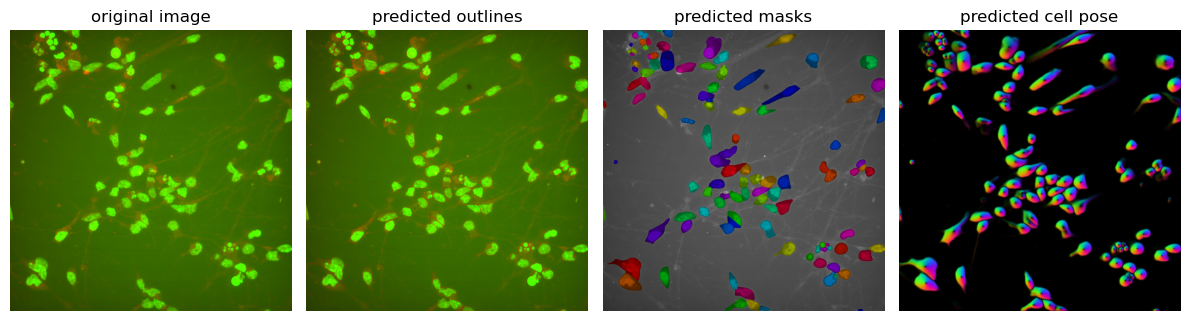

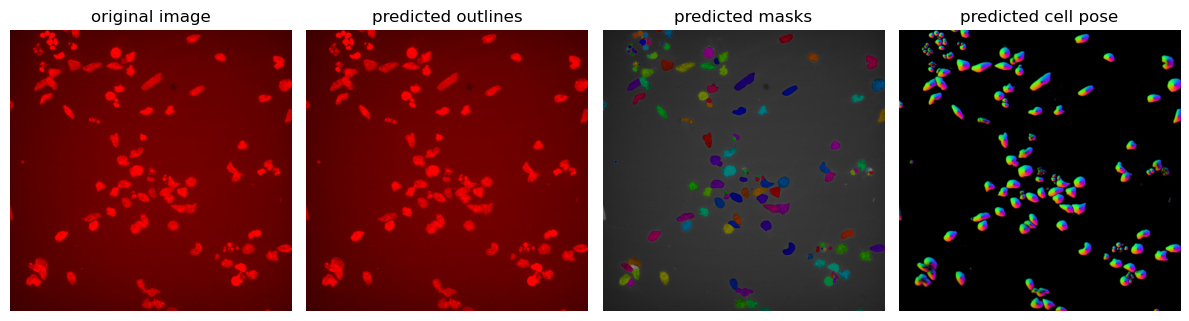

In [55]:
def examine_all(img_selected_channels, masks, flows):
    fig = plt.figure(figsize=(12, 5))
    vmin_target = 0.0
    vmax_target = np.percentile(img_selected_channels, 99.5)  # or try 99, 99.8, etc.
    img_display_adjusted = np.clip(
        (img_selected_channels - vmin_target) / (vmax_target - vmin_target + 1e-10),
        0,
        1,
    )
    plot.show_segmentation(
        fig,
        img_display_adjusted,
        masks,
        flows[0],
    )
    plt.tight_layout()
    plt.show()


examine_all(img_selected_channels, masks_cells, flows_cells)
examine_all(img_nuclei_only, masks_nuclei, flows_nuclei)

## Run Cellpose-SAM on folder of images

if you have many large images, you may want to run them as a loop over images



In [ ]:
masks_ext = ".png" if image_ext == ".png" else ".tif"
for i in trange(len(files)):
    f = files[i]
    img = io.imread(f)
    masks, flows, styles = model.eval(img, batch_size=32, flow_threshold=flow_threshold, cellprob_threshold=cellprob_threshold,
                                  normalize={"tile_norm_blocksize": tile_norm_blocksize})
    io.imsave(dir / (f.stem + "_masks" + masks_ext), masks)

if you have small images, you may want to load all of them first and then run, so that they can be batched together on the GPU

In [ ]:
print("loading images")
imgs = [io.imread(files[i]) for i in trange(len(files))]

print("running cellpose-SAM")
masks, flows, styles = model.eval(imgs, batch_size=32, flow_threshold=flow_threshold, cellprob_threshold=cellprob_threshold,
                                  normalize={"tile_norm_blocksize": tile_norm_blocksize})

print("saving masks")
for i in trange(len(files)):
    f = files[i]
    io.imsave(dir / (f.stem + "_masks" + masks_ext), masks[i])

to save your masks for ImageJ, run the following code:

In [ ]:
for i in trange(len(files)):
    f = files[i]
    masks0 = io.imsave(dir / (f.name + "_masks" + masks_ext))
    io.save_rois(masks0, f)